<a href="https://colab.research.google.com/github/fmejias/CienciasDeLosDatosTEC/blob/master/MatematicasCienciasDeLosDatos/TP4/TP4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matemáticas para Ciencias de los Datos
# Trabajo práctico 4

- Professor: M.Sc.Saul Calderon.

- Students: 
    - María Auxiliadora Mora, Instituto Tecnológico de Costa Rica  
    - Felipe Alberto Mejías Loría, Instituto Tecnológico de Costa Rica. 

- June 15th, 2019   

In [0]:
# Libraries required for the exercises
from __future__ import print_function
import torch as torch
import numpy as np
import random
import math
from sympy import *

import torch.distributions as distrib

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from numpy import linalg as linalg

# 1) Optimización de funciones (100 puntos)



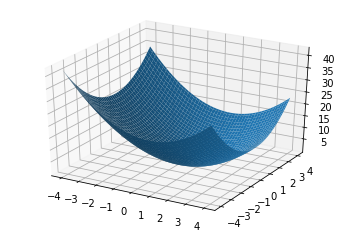

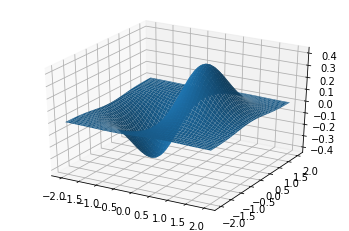

In [38]:
def optimizacion():  
  # Exercise 1.a
  def plot_func1():
    """
    Graph the surface
    """
    def f_a(x,y):
      return ((np.power(x-0.7, 2))+(np.power(y-0.5, 2)))

    x = np.linspace(-4, 4, 100)
    y = np.linspace(-4, 4, 100)

    X, Y = np.meshgrid(x, y)
    Z = f_a(X,Y)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z)

    plt.show()
    
  def plot_func2():
    """
    Graph the surface
    """
    def f_b(x,y):
      exp = -np.power(x, 2)-np.power(y, 2)
      return x*(np.power(2.71828, exp))

    x = np.linspace(-2, 2, 100)
    y = np.linspace(-2, 2, 100)

    X, Y = np.meshgrid(x, y)
    Z = f_b(X,Y)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z)

    plt.show()
    
  # Plot both functions
  plot_func1()
  plot_func2()

# Plot exercise 4.2.a
optimizacion()
  
  
 

# 2) Implemente el algoritmo del descenso del gradiente (50 puntos)

In [42]:
def funct1():
  x = Symbol('x')
  y = Symbol('y')
  return (x-0.7)**2 + (y-0.5)**2

def funct2():
  x = Symbol('x')
  y = Symbol('y')
  return x * ((N(E))**(-x**2 -y**2))

def gradient_descent(function, previousX, previousY, alpha = 0.01):
  x = Symbol('x')
  y = Symbol('y')
  
  # First partial derivative with respect to x
  fdx = function.diff(x)

  # First partial derivative with respect to y
  fdy = function.diff(y)
  
  # Initialize Parameters
  iterations = 0
  precision = 1/1000000
  maximumIterations = 1000
  
  while True:
    gradientX = N(fdx.subs(x, previousX).subs(y, previousY)).evalf()
    gradientY = N(fdy.subs(y, previousY)).subs(x, previousX).evalf()
    currentX  = previousX - alpha * gradientX
    currentY  = previousY - alpha * gradientY

    # Stop the loop due to so many iterations
    iterations += 1
    if iterations > maximumIterations:
      print('Function = %s' % function)
      print("Too many iterations\n")
      break

    if abs(currentX - previousX) <= precision and abs(currentY - previousY) <= precision:
      print('Function = %s' % function)
      print('Number of iterations = %d' % (iterations))
      print('Minimum value in X(x0) = %f' % (currentX))
      print('Minimum value in Y(y0) = %f\n' % (currentY))
      break

    # Update x and y parameters
    previousX = currentX
    previousY = currentY
    
  
    
# Test gradient descent for Function 1 and Function 2
gradient_descent(funct1(), previousX = 3, previousY = 3)
gradient_descent(funct2(), previousX = 1, previousY = 1)



Function = (x - 0.7)**2 + (y - 0.5)**2
Number of iterations = 537
Minimum value in X(x0) = 0.700045
Minimum value in Y(y0) = 0.500049

Function = 2.71828182845905**(-x**2 - y**2)*x
Too many iterations



#3) Implemente el algoritmo de Newton-Raphson, para cada función. (40 puntos)

In [43]:
def funct1():
  x = Symbol('x')
  y = Symbol('y')
  return (x-0.7)**2 + (y-0.5)**2

def funct2():
  x = Symbol('x')
  y = Symbol('y')
  return x * ((N(E))**(-x**2 -y**2))

def newton_raphson(function, previousX, previousY):
  x = Symbol('x')
  y = Symbol('y')
  
  # First partial derivative with respect to x
  fdx = function.diff(x)
  
  # Second partial derivative with respect to x
  second_fdx = fdx.diff(x)

  # First partial derivative with respect to y
  fdy = function.diff(y)
  
  # Second partial derivative with respect to y
  second_fdy = fdy.diff(y)
  
  # Initialize Parameters
  iterations = 0
  precision = 1/1000000
  maximumIterations = 15
  
  while True:
    substituteFirstDerivativeX = N(fdx.subs(x, previousX).subs(y, previousY)).evalf()
    substituteSecondDerivativeX = N(second_fdx.subs(x, previousX).subs(y, previousY)).evalf()
    substituteFirstDerivativeY = N(fdy.subs(y, previousY)).subs(x, previousX).evalf()
    substituteSecondDerivativeY = N(second_fdy.subs(y, previousY)).subs(x, previousX).evalf()
    currentX  = previousX - (substituteFirstDerivativeX/substituteSecondDerivativeX)
    currentY  = previousY - (substituteFirstDerivativeY/substituteSecondDerivativeY)

    # Stop the loop due to so many iterations
    iterations += 1
    if iterations > maximumIterations:
      print('Function = %s' % function)
      print("Too many iterations\n")
      break

    if abs(substituteFirstDerivativeX) <= precision and abs(substituteFirstDerivativeY) <= precision:
      print('Function = %s' % function)
      print('Number of iterations = %d' % (iterations))
      print('Minimum value in X(x0) = %f' % (currentX))
      print('Minimum value in Y(y0) = %f\n' % (currentY))
      break

    # Update x and y parameters
    previousX = currentX
    previousY = currentY
    
  
    
# Test Newton Raphson for Function 1 and Function 2
newton_raphson(funct1(), previousX = 3, previousY = 3)
newton_raphson(funct2(), previousX = 1, previousY = 1)

Function = (x - 0.7)**2 + (y - 0.5)**2
Number of iterations = 2
Minimum value in X(x0) = 0.700000
Minimum value in Y(y0) = 0.500000

Function = 2.71828182845905**(-x**2 - y**2)*x
Number of iterations = 12
Minimum value in X(x0) = 0.707107
Minimum value in Y(y0) = 4.014510

